In [27]:
library(dplyr)
library(corrplot)
library(dplyr)
library(tidyquant)
library(car)
library(forecast)
library(TTR)
library(lubridate)
library(xts)
library(dynlm)

In [25]:
tickers = "^GSPC" # Market and a risk free asset 
start_date = as.Date('2022-01-06')
end_date = as.Date('2022-09-12')

prices <- tickers %>% 
  tq_get(get = "stock.price", from = start_date, to = end_date) %>% 
  select(date, close) %>%
  mutate(date = as.Date(date)) 

prices = as.xts(prices$close, order.by = prices$date)

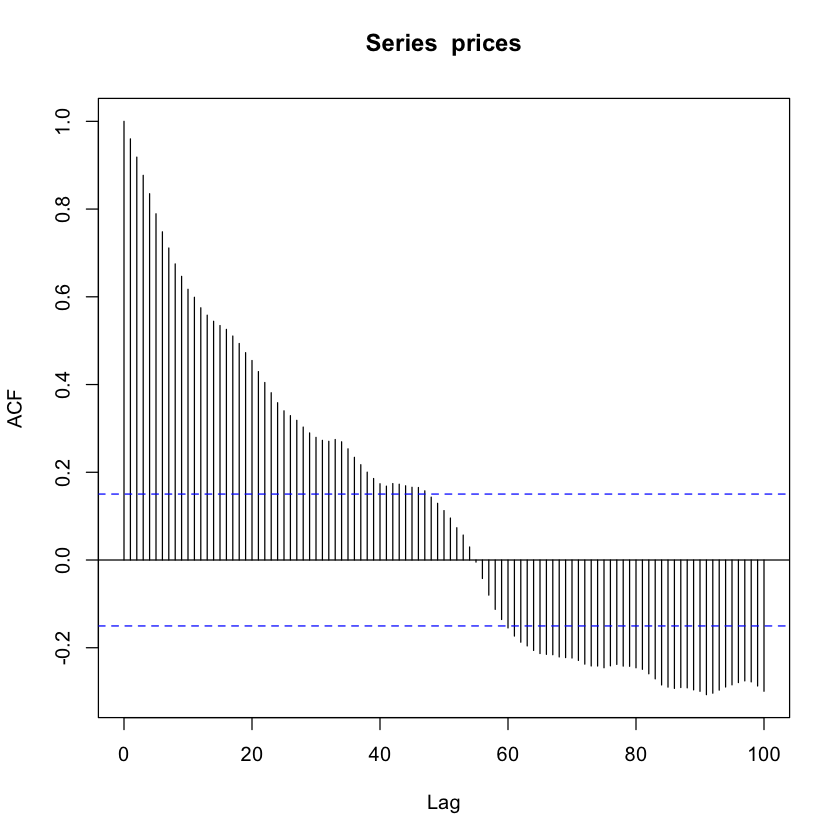

In [24]:
acf(prices, lag.max = 100)

In [43]:
estimate_trend_and_seasonality = function(ts, period_lag = 0 ){
  if (period_lag == 0) {
      ts = ts
      date_ind = index(ts)
        } else {
        ts = diff(ts, lag = period_lag)
        date_ind =  index(ts)[-period_lag]
        }
  
  date_ind = index(ts)
  # define the time points and evenly space them
  time_points = c(1:length(ts))
  time_points = c(time_points - min(time_points))/ max(time_points)
  x1 = time_points 
  x2 = time_points ^2
  rates_ts0 = ts(ts, start = , freq = 4)
  
  # Models
   ma_fit = ksmooth(time_points, ts, kernel = 'box') # Moving Average
  lm_fit = lm(ts ~ x1 + x2) # Parametric Quadratic Model 
  rates_local = loess(ts ~ x1) # Local Polynomial Model 
  spline_fit = gam(ts ~ s(x1)) # Splines Model 
  sin_cos_model = dynlm(rates_ts0 ~ harmon(rates_ts0)) # Harmonic model (Seasonal Estimation)
  seasonal_mu = dynlm(rates_ts0 ~ season(rates_ts0)- 1) # ANOVA model (Seasonal Estimation)

  # Estimation 
  df_estimate = data.frame(

    'Data' = ts, 
    'MA_model' =  ma_fit$y,
    'ParaQuad_model' = fitted( lm_fit), 
    'LocalPoly_model' = fitted( rates_local), 
    'Spline_model' = fitted( spline_fit), 
    'SineCosine_model' = fitted( sin_cos_model), 
    'Anova_model' = fitted( seasonal_mu)
  ) %>% as.xts(order.by = date_ind)
  
  resids = data.frame(

    'MA_model' = ts - df_estimate$MA_model, 
    'ParaQuad_model' = ts - df_estimate$ParaQuad_model,
    'LocalPoly_model' = ts  - df_estimate$LocalPoly_model,
    'Spline_model' = ts - df_estimate$Spline_model, 
    'SineCosine_model' = residuals( sin_cos_model), 
    'Anova_model' = residuals( seasonal_mu)
  ) %>% as.xts(order.by = date_ind)
  
  model_list = c(ma_fit, lm_fit, rates_local, spline_fit, sin_cos_model, seasonal_mu)
  return( list('Models' = model_list, 'Estimates' = df_estimate, 'Residuals' = resids) )
}


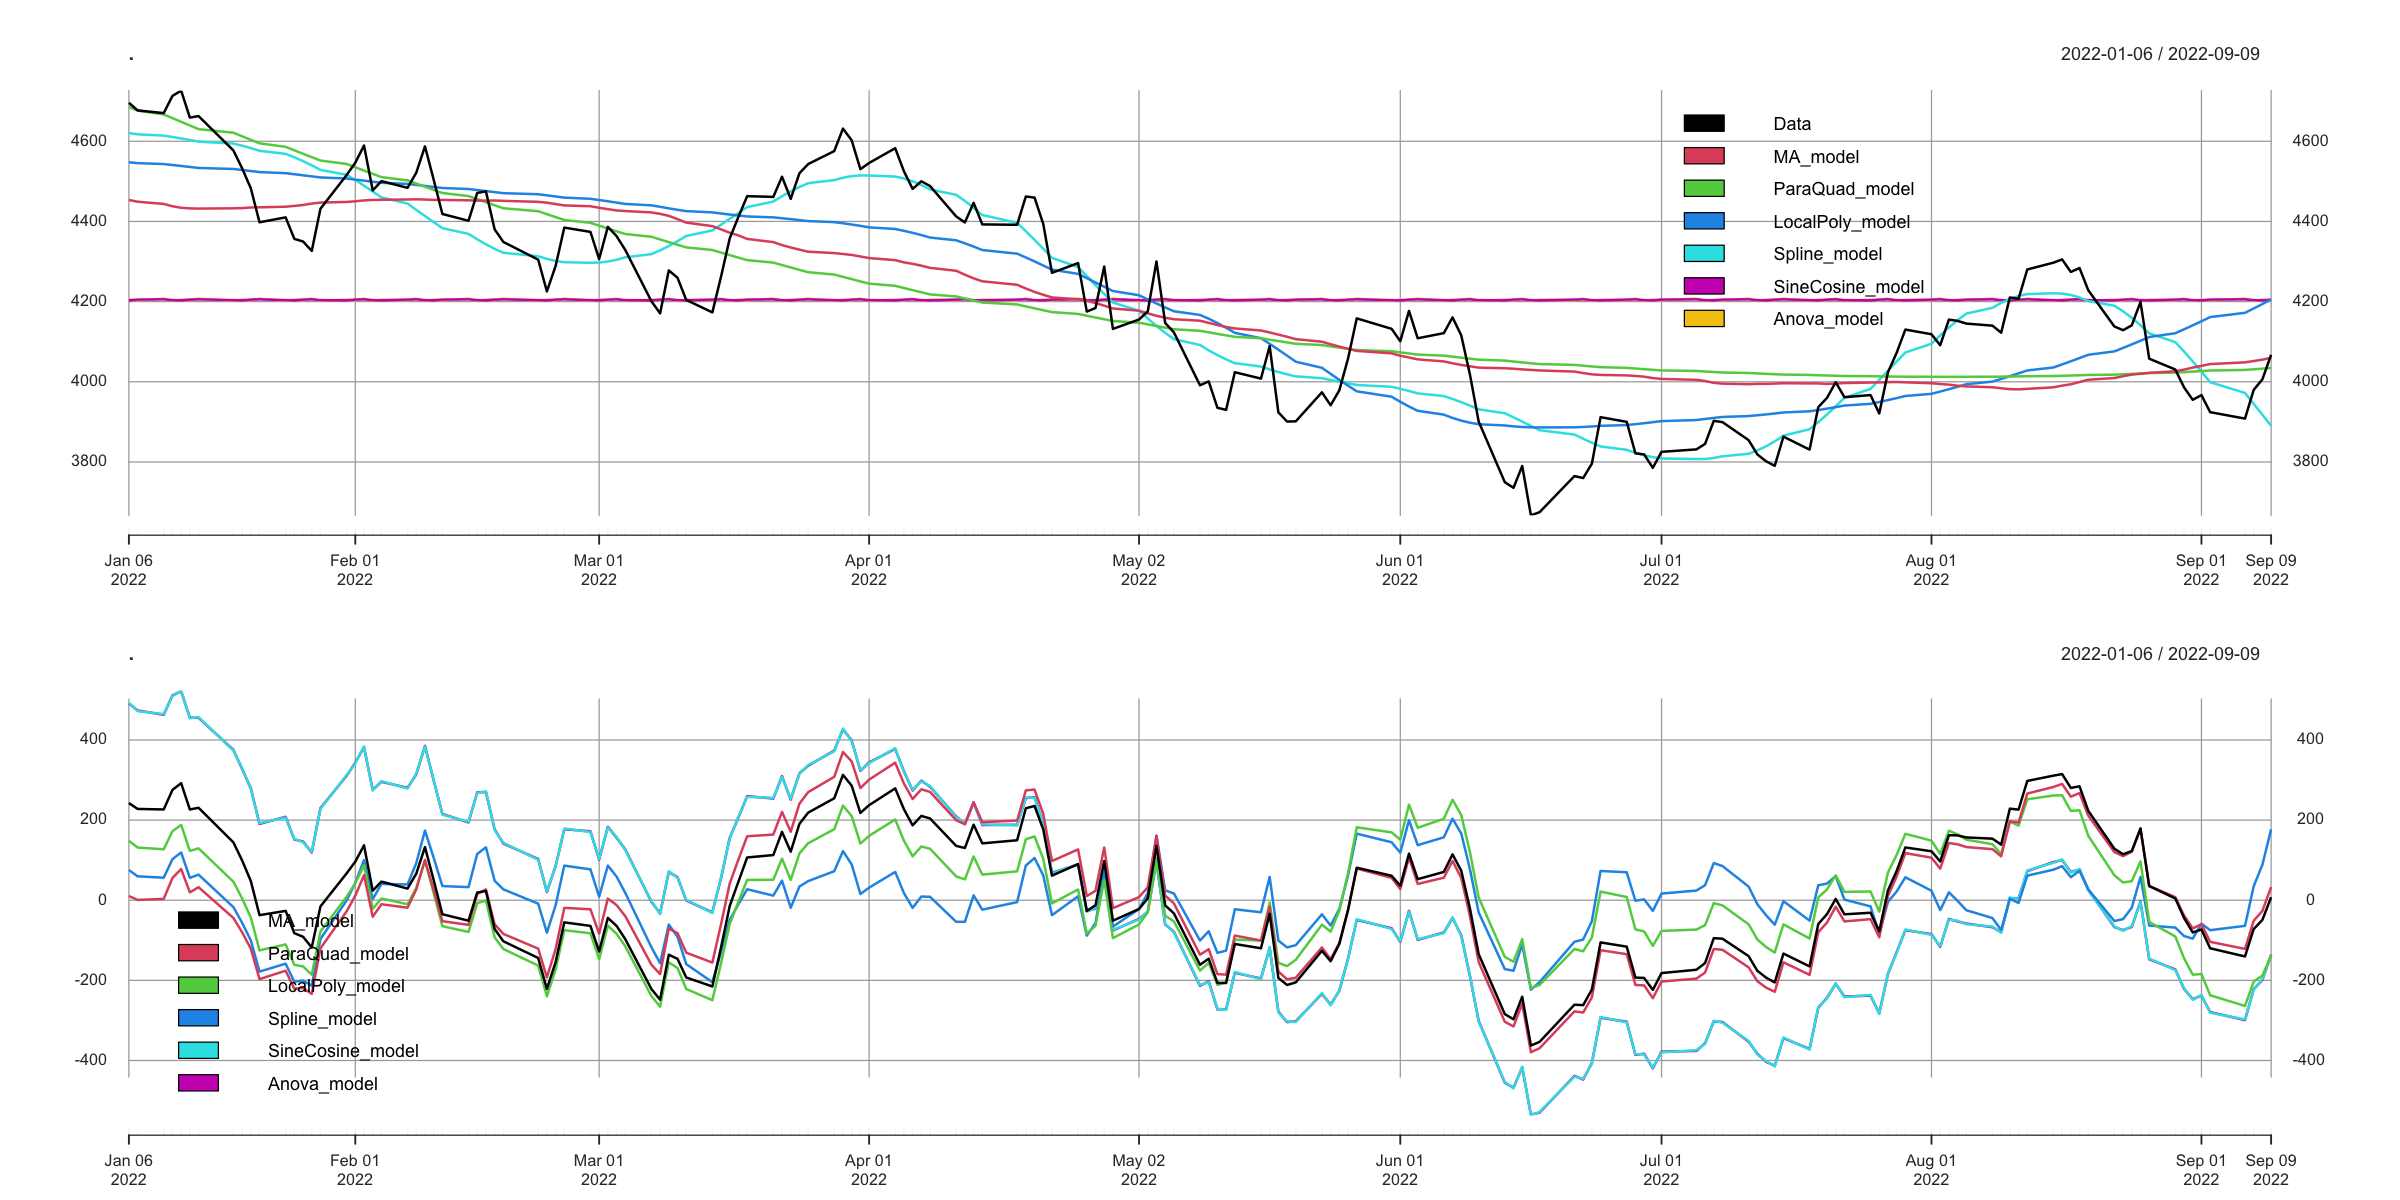

In [50]:
library(mgcv)
d = estimate_trend_and_seasonality(prices)

options(repr.plot.width=20, repr.plot.height=10)
par(mfrow = c(2, 1))
d$Estimates  %>% plot(legend.loc = 'topright')
d$Residuals %>% plot(legend.loc = 'bottomleft')